In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, json
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [3]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
NCOLS = 4
SUFFIX = 2020
SUFFIX_STR = '_%d' % SUFFIX

In [4]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

### Reading data...

In [5]:
H = json.load(open('results/hindex_10a_full_%d.json' % SUFFIX))
C = json.load(open('results/cits_10a_full_%d.json' % SUFFIX))
P = json.load(open('results/papers_10a_full_%d.json' % SUFFIX))
WS = json.load(open('results/ws_10a_full_%d.json' % SUFFIX))
WP = json.load(open('results/wp_10a_full_%d.json' % SUFFIX))
CL = json.load(open('results/citlist_10a_full_%d.json' % SUFFIX))
Y = json.load(open('results/birth_10a_full_%d.json' % SUFFIX))
CH = json.load(open('results/ch_10a_full_%d.json' % SUFFIX))
FOS = json.load(open('results/fos_10a_full_%d.json' % SUFFIX))

unique = np.unique(FOS)

H = np.asarray(H)
C = np.asarray(C)
P = np.asarray(P)
WS = np.asarray(WS)
WP = np.asarray(WP)
CL = np.asarray(CL)
Y = np.asarray(Y)
CH = np.asarray(CH)
FOS = np.asarray(FOS)
#TODO ajeitar o HINDEX pra rank funcionar

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
print(len(P[P >= 10]))
print(len(C[C >= 200]))

2629854
2630181


In [6]:
def fos_sort(max_ws, fos):
    values = []
    fs = []
    count = []
    for field in unique:
        group = max_ws[fos == field]
        if len(group) < 500:
            continue
        median = np.percentile(group, 50)
        fs.append(field)
        values.append(median)
        count.append(len(group))
    values = np.asarray(values)
    fs = np.asarray(fs)
    count = np.asarray(count)
    idxs = np.argsort(values)
    values = values[idxs]
    fs = fs[idxs]
    count = count[idxs]
    
    return fs, count

In [7]:
fos_sorted, _ = fos_sort(WS, FOS)
for f in fos_sorted:
    print(f)

95457728.0
142362112.0
138885662.0
144024400.0
17744445.0
2908647359.0
162324750.0
33923547.0
144133560.0
127313418.0
15744967.0
205649164.0
127413603.0
41008148.0
39432304.0
121332964.0
71924100.0
86803240.0
185592680.0
192562407.0


### Basic plots

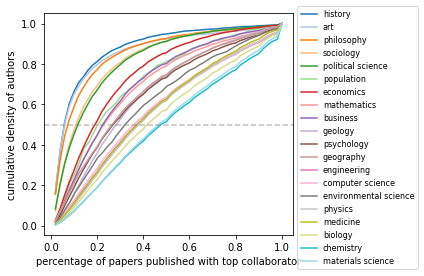

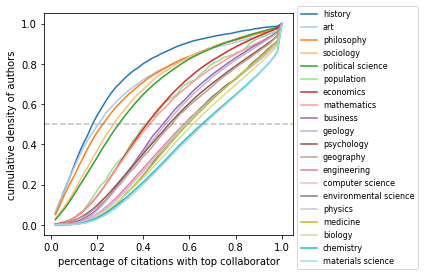

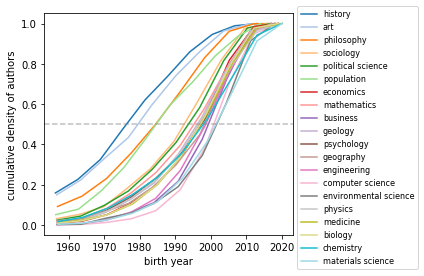

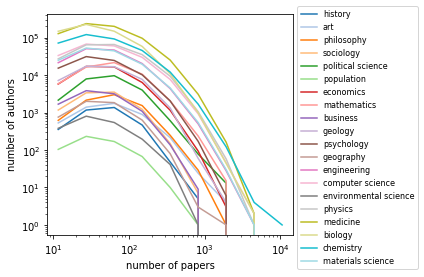

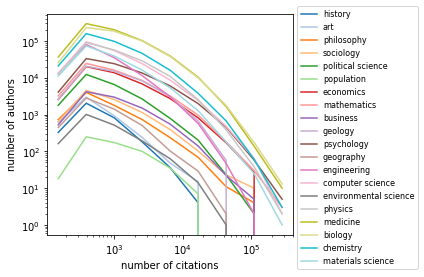

In [9]:
def plot_hist(fig, group, bins, field_name, cumulative):
    y,x = np.histogram(group, bins=bins)
    if cumulative:
        y = np.cumsum(y)
        fig.plot(x[1:], y/y[-1], label=field_name)
    else:
        bins_center = 0.5*(x[:-1]+x[1:])
        fig.plot(bins_center,y, label=field_name)
    
def basic_hist(unique, fos, data, key, suffix, bins, yscale=None, xscale=None, cumulative=False):
    fig, ax = plt.subplots()
    
    for field in unique:
        group = data[fos == field]
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        plot_hist(ax, group, bins, field_name, cumulative)

    ax.legend(bbox_to_anchor=(1.0, 1.05), prop={'size': 8})
    if cumulative:
        ax.axhline(0.5, xmin=0, xmax=1, ls='--', color='grey', alpha=0.5)
    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)
    ax.set_title(labels_description[key]['title'])
    ax.set_xlabel(labels_description[key]['x'])
    ax.set_ylabel(labels_description[key]['y'])
    fig.subplots_adjust(right=0.2)
    fig.tight_layout()
    fig.savefig('outputs/fos_hist_%s%s.pdf' % (key,suffix))
    fig.show()

labels_description = {
    'max_colabs': {'x': 'percentage of papers published with top collaborator', 'y': 'cumulative density of authors', 'title': ''},
    'max_ws': {'x': 'percentage of citations with top collaborator', 'y': 'cumulative density of authors', 'title': ''},
    'birth': {'x': 'birth year', 'y': 'cumulative density of authors', 'title': ''},
    'papers': {'x': 'number of papers', 'y': 'number of authors', 'title': ''},
    'total_cits': {'x': 'number of citations', 'y': 'number of authors', 'title': ''} 
}    

basic_hist(fos_sorted, FOS, WP, 'max_colabs', suffix=SUFFIX_STR, bins=50, cumulative=True) # papers
basic_hist(fos_sorted, FOS, WS, 'max_ws', suffix=SUFFIX_STR, bins=50, cumulative=True) # citações
basic_hist(fos_sorted, FOS, Y, 'birth', suffix=SUFFIX_STR, bins=10, cumulative=True)
xspace = np.logspace(np.log10(min(P)), np.log10(max(P)), 10)
basic_hist(fos_sorted, FOS, P, 'papers', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')
xspace = np.logspace(np.log10(min(C)), np.log10(max(C)), 10)
basic_hist(fos_sorted, FOS, C, 'total_cits', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')

In [22]:
fos_infos.head()

,field_id,rank,normalized_name
0,417682,16758,night air
1,1443462,15557,immobiliser
2,1576492,13013,matrix pencil
3,2657588,13530,combinatorial topology
4,3079626,8569,quantum electrodynamics


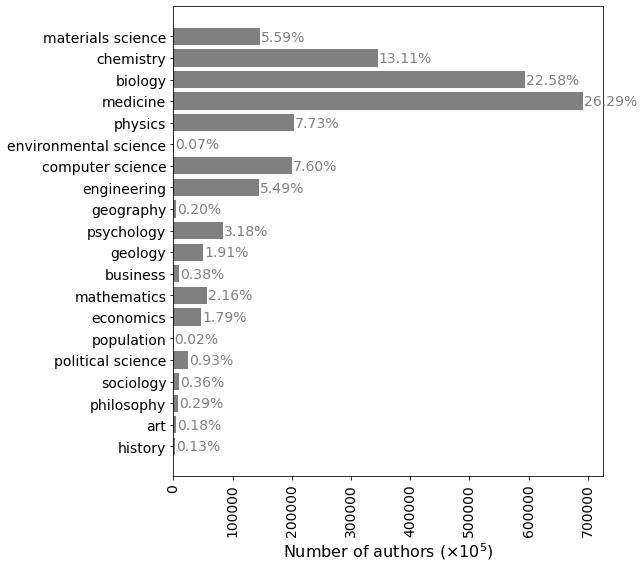

In [42]:
# Distribution of the authors per FOS

_, count = fos_sort(WS, FOS)
labels = [fos_infos[fos_infos['field_id'] == u].iloc[0, -1] for u in fos_sorted]

plt.figure(figsize=(9,8))
plt.barh(np.arange(1, len(count)+1), count, tick_label=labels, color='gray')
# plt.title('total of authors = %d' % len(FOS))
plt.xticks(rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
ax = plt.gca()
for i, v in enumerate(count):
    ax.text(v + 1500, i + .8, "%.2f%%" % (100*v/len(FOS)), color='gray', size=14)
plt.xlabel("Number of authors ($\\times 10^5$)", fontsize=16)
plt.tight_layout()
plt.savefig('authors_distribution_%d.pdf' % SUFFIX)

### 2d histograms

In [24]:
def get_rows_cols(unique):
    N = len(unique)
    if N % NCOLS == 0:
        rows = N//NCOLS
    else:
        rows = N//NCOLS + 1
    cols = NCOLS
    return rows,cols

def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im

    
def hist2d(unique, fos, xdata, ydata, xkey, ykey, suffix, xbins, ybins, yscale=None, xscale=None):
    rows,cols = get_rows_cols(unique)
    print(rows,cols)
    fig, axs = plt.subplots(figsize=(3*cols, 3*rows), nrows=rows, ncols=cols, sharex=True, sharey=True)
    i = 0
    for field in unique:
        xgroup = xdata[fos == field]
        ygroup = ydata[fos == field]
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, ygroup, xbins, ybins, field_name=field_name)
        
        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%cols == 0: 
            ax.set_ylabel(ykey)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xkey)
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(unique)%cols
    if empty_plots != 0: 
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s%s.pdf' % (xkey, ykey, suffix))
    fig.show()
    

5 4


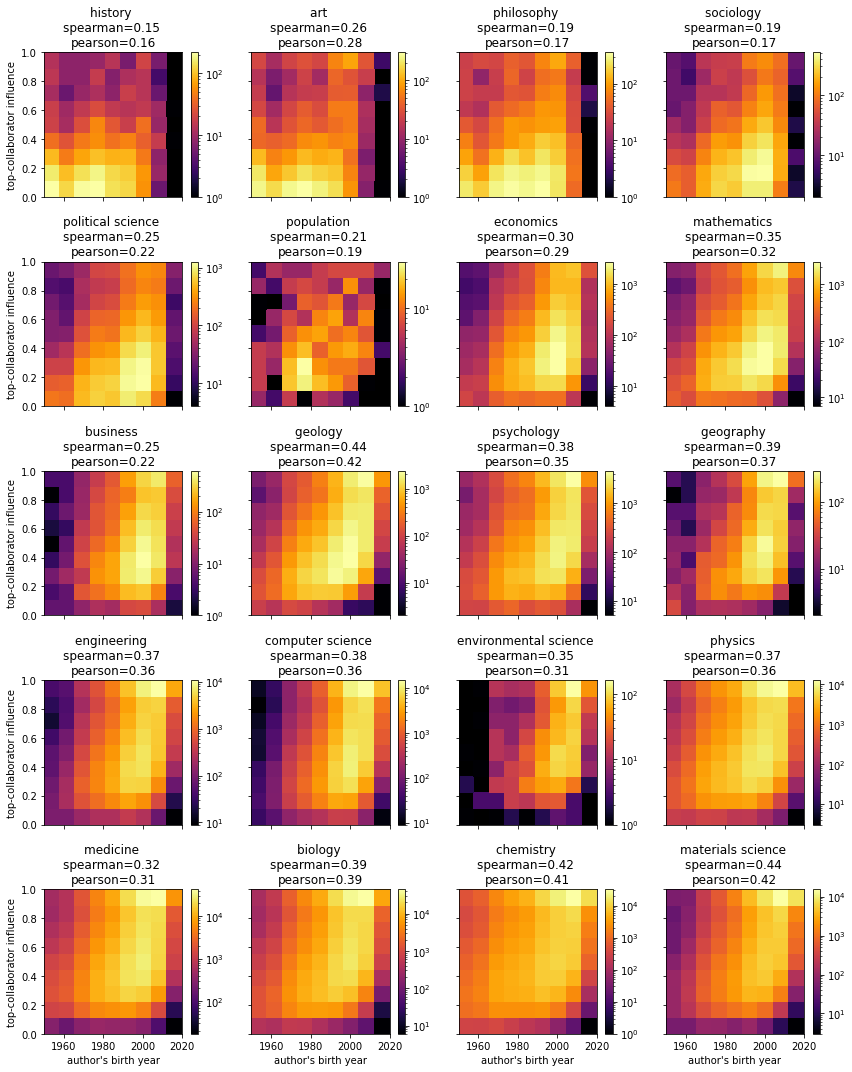

In [48]:
# xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
# ybins = np.linspace(min(WS), max(WS), 10)
# hist2d(fos_sorted, FOS, P, WS, 'papers', 'max_ws', SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

xbins = np.linspace(min(Y), max(Y), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(fos_sorted, FOS, Y, WS, 'author\'s birth year', 'top-collaborator influence', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale=None, yscale=None)

# xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
# ybins = np.linspace(min(Y), max(Y), 10)
# hist2d(fos_sorted, FOS, P, Y, 'papers', 'birth', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

# xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
# ybins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
# hist2d(fos_sorted, FOS, P, C, 'papers', 'total_cits', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale='log')

# xbins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
# ybins = np.linspace(min(Y), max(Y), 10)
# hist2d(fos_sorted, FOS, C, Y, 'total of citations', 'author\'s birth year', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

### Impact of the top collaborator

In [8]:
def get_rows_cols(unique):
    N = len(unique)
    if N % NCOLS == 0:
        rows = N//NCOLS
    else:
        rows = N//NCOLS + 1
    cols = NCOLS
    return rows,cols

def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im

    
def hist2d(unique, fos, xdata, ydata, xkey, ykey, suffix, xbins, ybins, yscale=None, xscale=None):
    rows,cols = get_rows_cols(unique)
    print(rows,cols)
    fig, axs = plt.subplots(figsize=(3*cols, 3*rows), nrows=rows, ncols=cols, sharex=True, sharey=True)
    i = 0
    for field in unique:
        xgroup = xdata[fos == field]
        ygroup = ydata[fos == field]
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, ygroup, xbins, ybins, field_name=field_name)
        
        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%cols == 0: 
            ax.set_ylabel(ykey)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xkey)
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(unique)%cols
    if empty_plots != 0: 
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s%s.pdf' % (xkey, ykey, suffix))
    fig.show()
    

In [9]:
def generic_before_after(suffix, _metric_before_after, xlabel, ylabel, outputname):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(3*cols, 2.7*rows), nrows=rows, ncols=cols) #, sharex=True, sharey=True)
    
    i = 0
    hafter_map = {}
    for field in fos_sorted:
        group = (FOS == field)
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im, hafter = _metric_before_after(ax, group, field_name=field_name)
        hafter_map[field] = hafter
    
        if i%cols == 0: 
            ax.set_ylabel(ylabel)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xlabel)
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_before_after_%d_%s.pdf' % (suffix, outputname))
    fig.show()
    
    return hafter_map

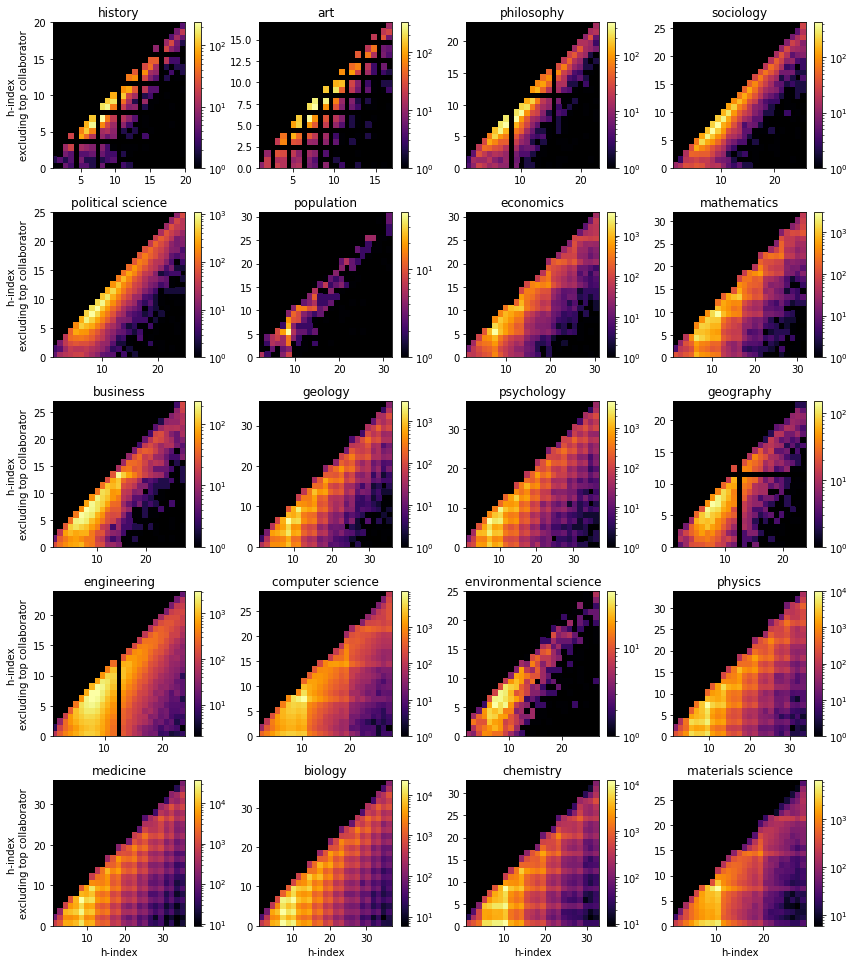

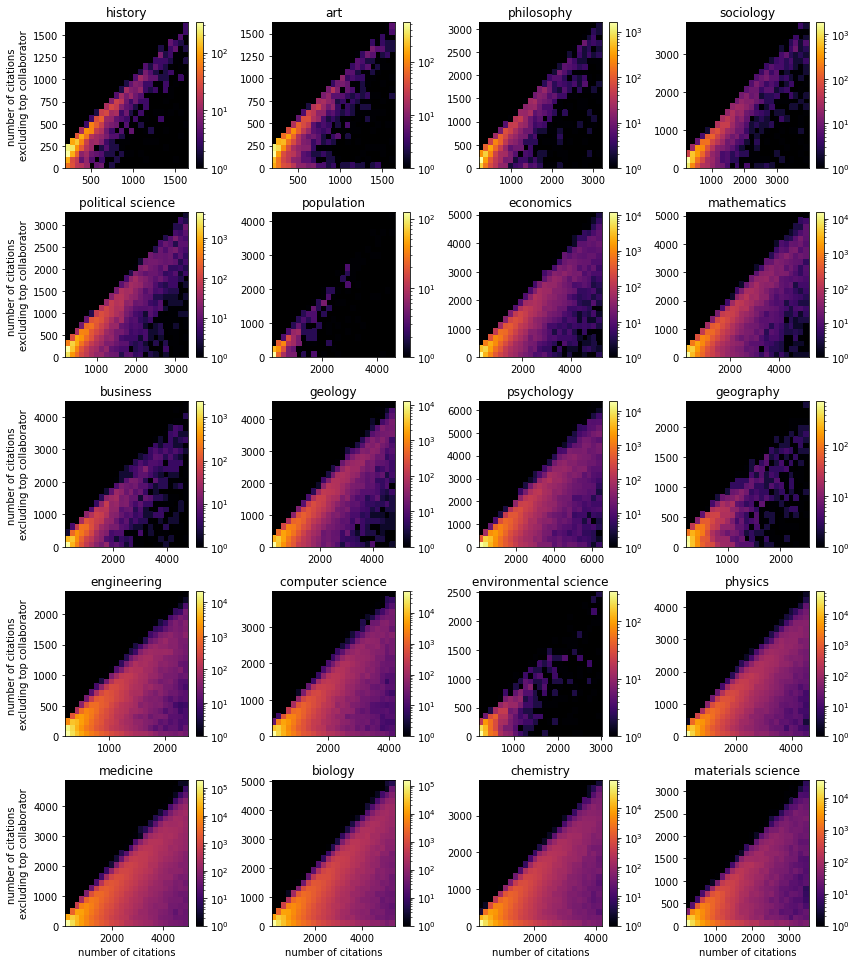

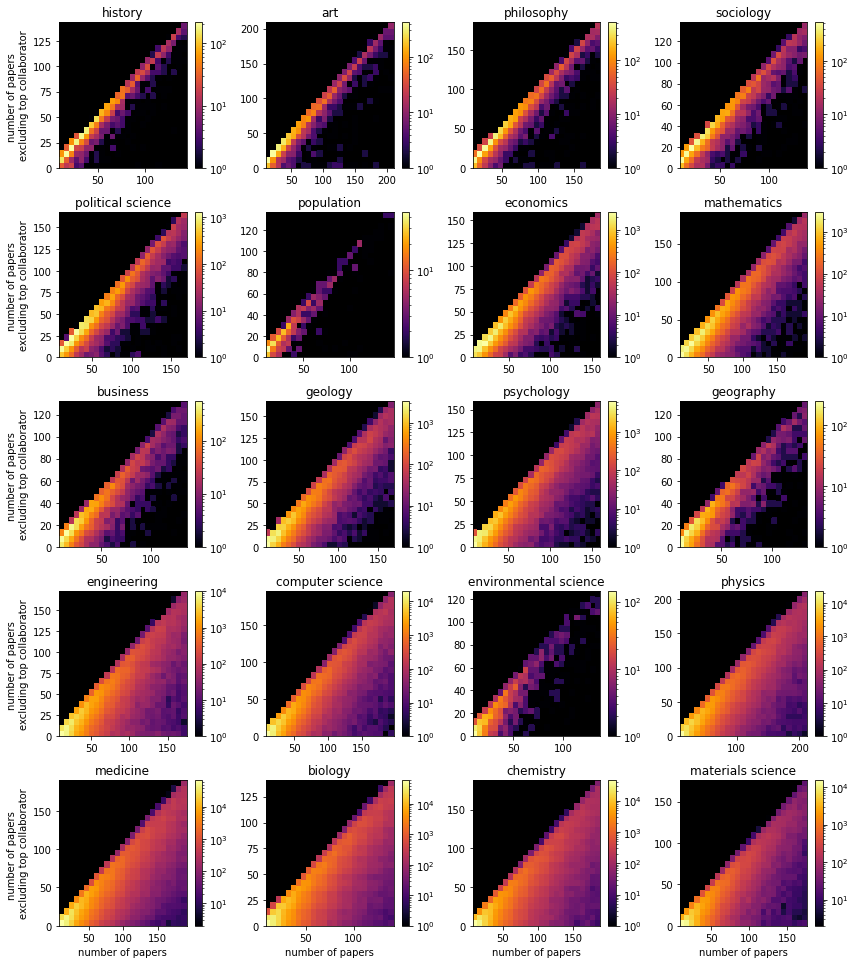

In [10]:
from s4_authors_stats import get_h_index

def _hindex_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    valid_h_index = H[idxs]
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    perc = np.percentile(hindex_before_l1, 95)
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= perc], hindex_after_l1[hindex_before_l1 <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, hindex_after 

hafter_map = generic_before_after(SUFFIX, _hindex_before_after, 'h-index', 'h-index \nexcluding top collaborator', 'hindex')



def _cits_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    cits_before = []
    cits_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        before = sum(acits)
        after = before - sum(ccits)
        
        cits_before.append(before)    
        cits_after.append(after)
    
    cits_before = np.asarray(cits_before)
    cits_after = np.asarray(cits_after)
    
    ax.set_facecolor("black")
    perc = np.percentile(cits_before, 95)
    im = ax.hist2d(cits_before[cits_before <= perc], cits_after[cits_before <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, cits_after 

citsafter_map = generic_before_after(SUFFIX, _cits_before_after, 'number of citations', 'number of citations \nexcluding top collaborator', 'citations')



def _papers_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    p_before = []
    p_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        before = len(acits)
        after = before - len(ccits)
        
        p_before.append(before)    
        p_after.append(after)
    
    p_before = np.asarray(p_before)
    p_after = np.asarray(p_after)
    
    ax.set_facecolor("black")
    perc = np.percentile(p_before, 95)
    im = ax.hist2d(p_before[p_before <= perc], p_after[p_before <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, p_after 

papersafter_map = generic_before_after(SUFFIX, _papers_before_after, 'number of papers', 'number of papers \nexcluding top collaborator', 'papers')

### Impact of the top collaborator on the authors' rankings

In [11]:
def rank(values, i, new_val):
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], i[-1])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = acits.copy() #json.loads(acits)
    for ctemp in ccits: #json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
#     print(hafter, i, acits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter

100%|██████████| 146983/146983 [00:04<00:00, 35092.56it/s]


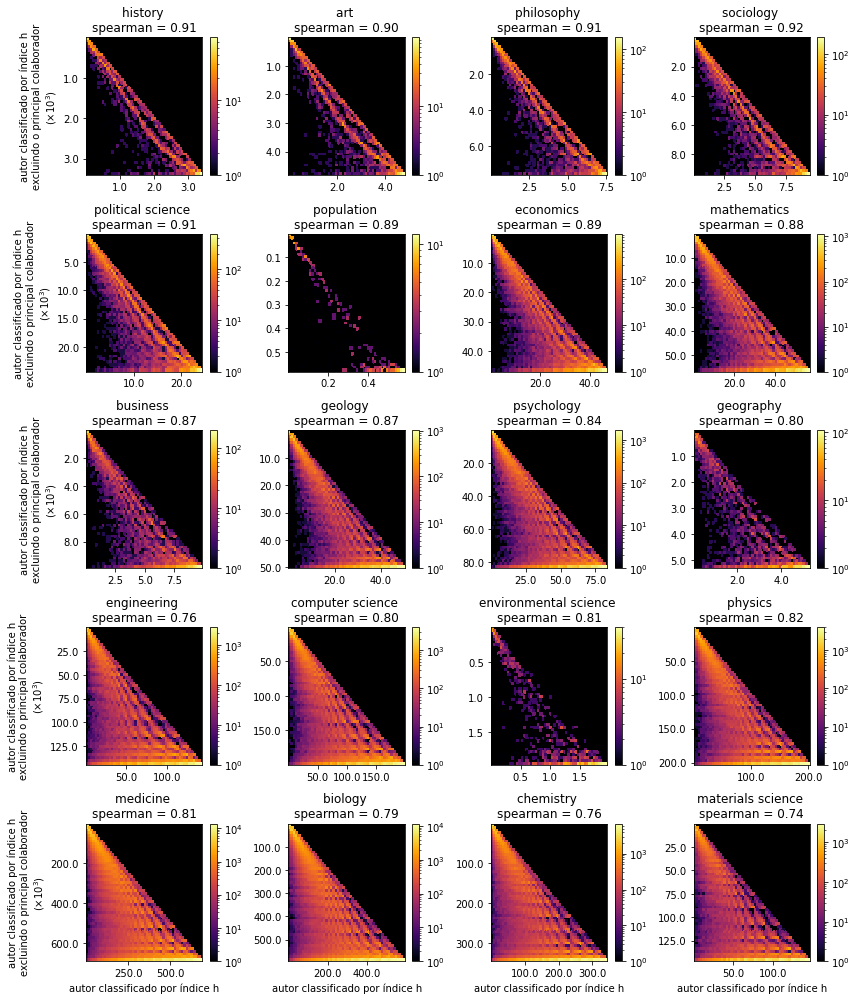

In [12]:
import tqdm
import matplotlib.ticker as tick
# from tqdm.auto import tqdm
def _plot_rank(ax, idxs, hindex_after, field_name):
    valid_h_index = H[idxs]
    
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(neg_hindex, valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \nspearman = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def format_axisx(x,y):
    return "%.1f" % (x/1000)
    
def plot_rank(hafter_map, suffix):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(3*cols, 2.8*rows), nrows=rows, ncols=cols) #sharex=True, sharey=True)
    
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank(ax, group, hafter_map[field], field_name=field_name)
    
        if i%cols == 0: 
#             ax.set_ylabel('author\'s rank by h-index\nexcluding their top collaborator\n($\\times 10^3$)')
            ax.set_ylabel('autor classificado por índice h\nexcluindo o principal colaborador\n($\\times 10^3$)')
        if int(i/cols) == rows-1:    
#             ax.set_xlabel('author\'s rank by h-index($\\times 10^3$)')
            ax.set_xlabel('autor classificado por índice h')
        ax.xaxis.set_major_formatter(tick.FuncFormatter(format_axisx));
        ax.yaxis.set_major_formatter(tick.FuncFormatter(format_axisx))
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
            
#     ax = plt.gca()
    
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_hrank_%d.pdf' % suffix)
    fig.show()
    
plot_rank(hafter_map, suffix=SUFFIX)


100%|██████████| 146983/146983 [00:00<00:00, 178416.48it/s]


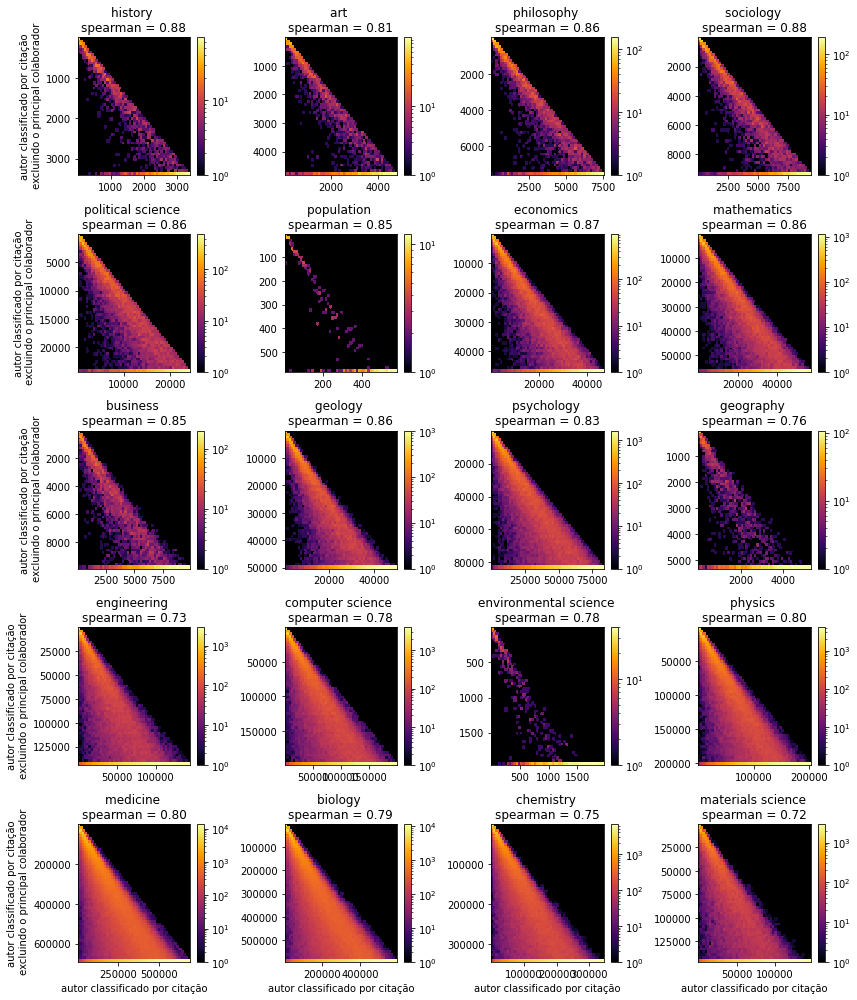

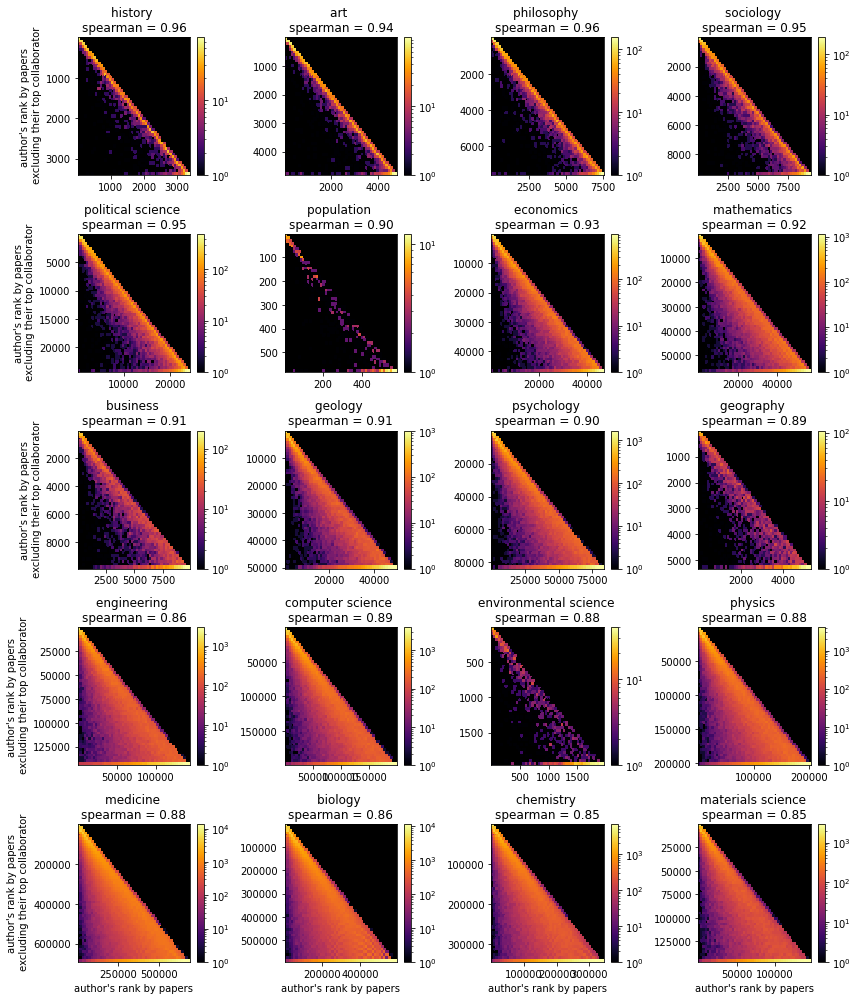

In [13]:
import tqdm
# from tqdm.auto import tqdm

def rank_cits(values, i, new_val):
    new_pair = np.array([(new_val[0], i[-1])], dtype=[('my_val1', int), ('my_val2', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_author(hindexbefore, i, citsafter):
    rafter = rank_cits(hindexbefore, i, (-citsafter,))
    return rafter

def _plot_rank_cits(ax, idxs, metric_after, field_name):
    valid_citation_list = [sum(temp) for temp in CH[idxs]]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_citation_list)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \nspearman = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank_metric(after_map, metric_rank, suffix, xlabel, ylabel, outname):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(3*cols, 2.8*rows), nrows=rows, ncols=cols) #sharex=True, sharey=True)
    
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = metric_rank(ax, group, after_map[field], field_name=field_name)
    
        if i%cols == 0: 
            ax.set_ylabel(ylabel)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xlabel)
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')

    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_rank_%s_%d.pdf' % (outname,suffix))
    fig.show()
    
# ylabel = 'author\'s rank by citations\n excluding their top collaborator'
# xlabel = 'author\'s rank by citations'
ylabel = 'autor classificado por citação\n excluindo o principal colaborador'
xlabel = 'autor classificado por citação'
outname = 'cits'
plot_rank_metric(citsafter_map, _plot_rank_cits, SUFFIX, xlabel, ylabel, outname)

# -----------------------------------------------------------------

def _plot_rank_papers(ax, idxs, metric_after, field_name):
    valid_papers_list = [len(temp) for temp in CH[idxs]]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_papers_list)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \nspearman = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


ylabel = 'author\'s rank by papers\n excluding their top collaborator'
xlabel = 'author\'s rank by papers'
outname = 'papers'
plot_rank_metric(papersafter_map, _plot_rank_papers, SUFFIX, xlabel, ylabel, outname)



5 4


100%|██████████| 146983/146983 [00:00<00:00, 179856.44it/s]


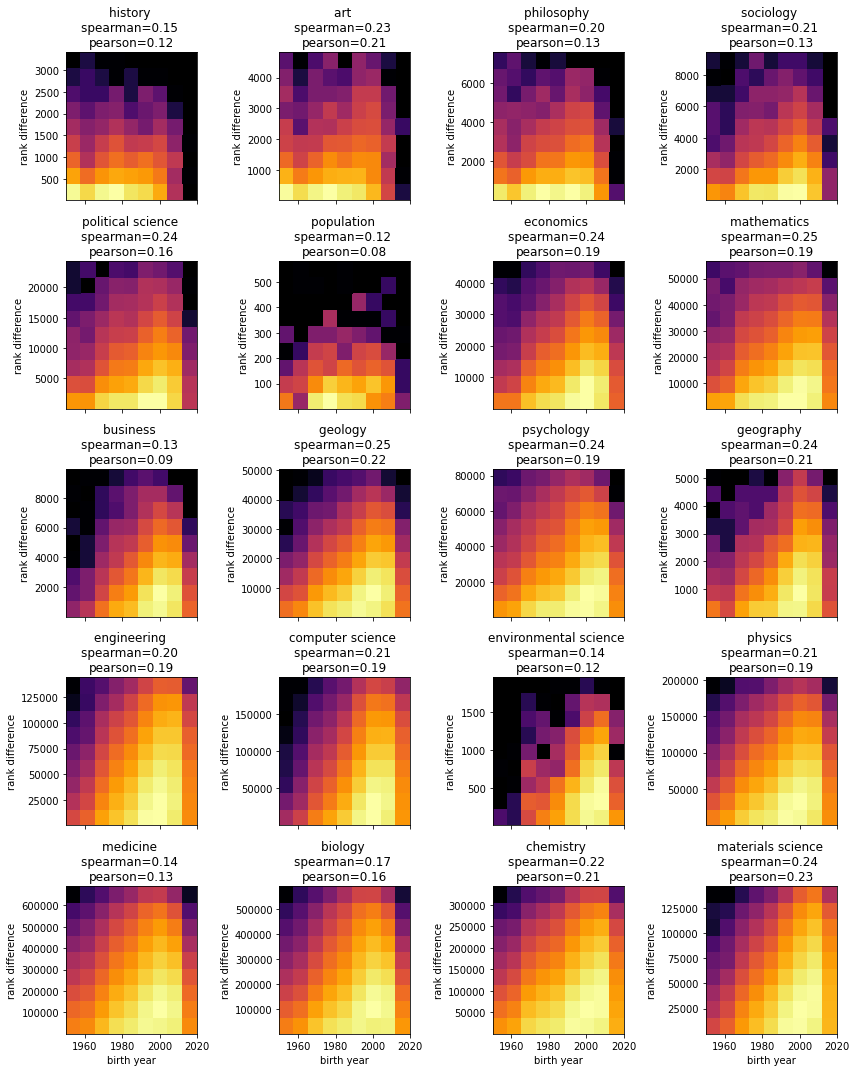

In [46]:
import tqdm
# from tqdm.auto import tqdm

def rank_cits(values, i, new_val):
    new_pair = np.array([(new_val[0], i[-1])], dtype=[('my_val1', int), ('my_val2', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_author(hindexbefore, i, citsafter):
    rafter = rank_cits(hindexbefore, i, (-citsafter,))
    return rafter

def _plot_rank_cits(ax, idxs, metric_after, field_name):
    valid_citation_list = [sum(temp) for temp in CH[idxs]]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_citation_list)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    return rankbefore, results


def rank_metric_birth(after_map, metric_rank, suffix, xlabel, ylabel, outname):
    rows,cols = get_rows_cols(unique)
    print(rows,cols)
    fig, axs = plt.subplots(figsize=(3*cols, 3*rows), nrows=rows, ncols=cols, sharex=True)
    
    xbins = np.linspace(min(Y), max(Y), 10)
    yscale = None
    xscale = None
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        r_before, r_after = metric_rank(ax, group, after_map[field], field_name=field_name)
    
    
        xgroup = Y[FOS == field]
        
        ax = axs[int(i/cols)][i%cols]
        
        ybins = np.linspace(min(r_before), max(r_before), 10)
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, r_after - r_before, xbins, ybins, field_name=field_name)
        
        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        ax.set_ylabel(ylabel)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xlabel)
    
        i += 1
    empty_plots = len(unique)%cols
    if empty_plots != 0: 
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    fig.tight_layout()
    fig.savefig('test%s.pdf' % (suffix))
    fig.show()

ylabel = 'rank difference' #'author\'s rank by citations\n excluding their top collaborator'
xlabel = 'birth year'
outname = 'cits'
rank_metric_birth(citsafter_map, _plot_rank_cits, SUFFIX, xlabel, ylabel, outname)

# --------------